In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
# from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Make dataset class

In [21]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotation_path, img_dir, img_size): # name2idx is encode classname as int, name2idx is encoder.
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = None
        self.img_data_all,  self.gt_classes_all, self.gt_bboxes_all = self.get_data()

    def __len__(self):
        return len(self.img_data_all)
    
    def __getitem__(self, index):
        return self.img_data_all[index], self.gt_bboxes_all[index], self.gt_classes_all[index]
    
    def scale_bounding_box(self, scale_width, scale_height, boxes_img_raw):
        boxes_img = [[float(i[ind] * scale_width) if ind % 2 == 0 else float(i[ind] * scale_height)
                                   for ind in range(len(i))] for i in boxes_img_raw]
        return boxes_img

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        boxes_all_scale = []
        img_paths, gt_classes_all, gt_boxes_all = parse_annotation(self.annotation_path, self.img_dir) # function from utils.py
        '''
        img_paths: [path1, path2, path3,...]
        gt_class_all: [[class1, class2,..], [class2,..], [class1, class3,..],...]
        gt_boxes_all: [[[x_min, y_min, x_max, y_max], [x_min, y_min, x_max, y_max],...],... ]
        '''
        count_check = 0
        for index, img_path in enumerate(img_paths):
            count_check += 1 
            if count_check >=3: # đang để 2 sample để test thôi, sau này sẽ xóa
                break
            if (not img_path) or (not os.path.exists(img_path)):
                continue
            image = io.imread(img_path) # width, height, chanel
            old_width = image.shape[1]
            old_height = image.shape[0]

            # resize
            image = resize(image, self.img_size)

            # after resize image, we need to adjust bounding box data to fit the new image
            scale_width = self.img_size[1]/old_width
            scale_height = self.img_size[0]/old_height
            boxes_img_scale = self.scale_bounding_box(scale_width, scale_height, gt_boxes_all[index])
            boxes_all_scale.append(torch.Tensor(boxes_img_scale))

            # convert to tensor and reshape chanel, width, height
            image = torch.from_numpy(image).permute(2,0,1)
            img_data_all.append(image)

            #encode class name
            self.name2idx = encode_class(gt_classes_all) # make dictionary of class and index of it {'class': index}
            classes = gt_classes_all[index]
            gt_idx = torch.Tensor([self.name2idx[class_name] for class_name in classes])
            gt_idxs_all.append(gt_idx)

        #padding bounding box and classes so that elements within (bên trong) them are the same size
        gt_idxs_all_padded = pad_sequence(gt_idxs_all, batch_first= True, padding_value=-1) # batch_first=True -> Batch, maxlenght, dim
        gt_boxes_all_padded = pad_sequence(boxes_all_scale, batch_first=True, padding_value=-1) # nếu batch_first=False -> maxlenght, batch, dim
        
        #stack all image to a Tensor
        imgs_stack = torch.stack(img_data_all, dim=0)
        # dữ liệu ở float32 sẽ đỡ tốn bộ nhớ hơn dữ liệu ở float64(default)
        return imgs_stack.to(dtype=torch.float32), gt_idxs_all_padded, gt_boxes_all_padded
        

In [22]:
annotations_path = "VOCdevkit/VOC2007/Annotations"
img_size = (200,300)
img_dir = "VOCdevkit/VOC2007/JPEGImages"

# Create dataset and dataloader

## Dataset

In [23]:
dataset = ObjectDetectionDataset(annotations_path, img_dir, img_size)

- All class and it's index

In [5]:
dataset.name2idx

{'chair': 0,
 'train': 1,
 'bottle': 2,
 'bird': 3,
 'aeroplane': 4,
 'pottedplant': 5,
 'diningtable': 6,
 'boat': 7,
 'dog': 8,
 'bus': 9,
 'sheep': 10,
 'car': 11,
 'horse': 12,
 'bicycle': 13,
 'motorbike': 14,
 'sofa': 15,
 'person': 16,
 'cow': 17,
 'cat': 18,
 'tvmonitor': 19}

## Dataloader

In [6]:
dataset.get_data()[1]

tensor([[ 0.,  0.,  0.,  0.,  0.],
        [11., -1., -1., -1., -1.]])

In [24]:
idx2name = decode_class(dataset.name2idx)
idx2name.update({-1: 'back'})

(<Figure size 1000x500 with 2 Axes>, <Axes: >)

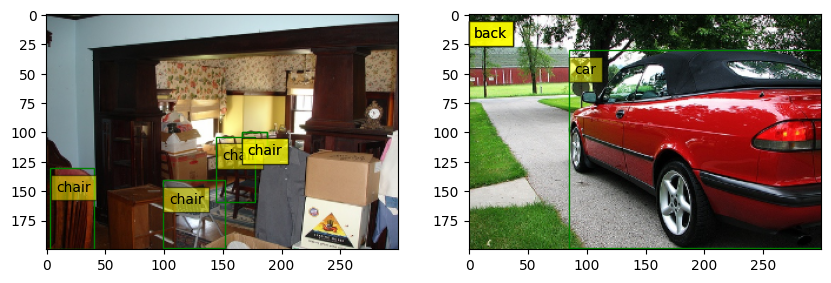

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
display_img(dataset.get_data()[0], fig, ax)
display_boundingbox(dataset.get_data()[2][0], [idx2name[int(i)] for i in dataset.get_data()[1][0]], fig, ax[0])
display_boundingbox(dataset.get_data()[2][1], [idx2name[int(i)] for i in dataset.get_data()[1][1]], fig, ax[1])


In [6]:
dataloader = DataLoader(dataset, batch_size=2)

### Visualize image and bounding box for all class in image

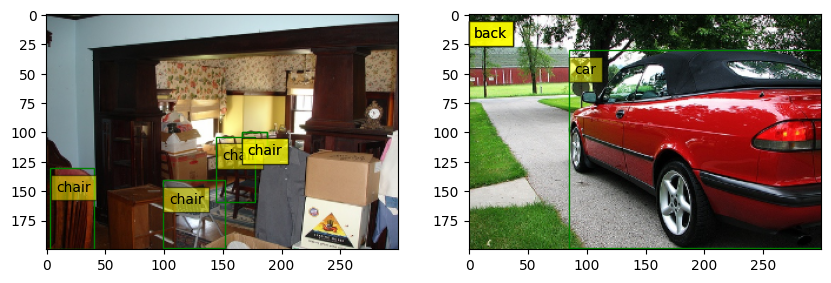

In [10]:
count_tesst = 0
for img_batch, gt_boxes_batch, gt_classes_batch in dataloader:
    if count_tesst == 2:
        break
    count_tesst +=1
    classes0 = [idx2name[int(i)] for i in gt_classes_batch[0]]
    classes1 = [idx2name[int(i)] for i in gt_classes_batch[1]]
    fig, ax = plt.subplots(1,2)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    fig, ax = display_img(img_batch, fig, ax) # ở đây đang để batch = 2 nên sẽ hiển thị 2 ảnh, sửa sau
    fig, _ = display_boundingbox(gt_boxes_batch[0], classes0, fig, ax[0])
    fig, _ = display_boundingbox(gt_boxes_batch[1], classes1, fig, ax[1])

# CNN Backbone

- Cho ảnh qua CNN để lấy feature map, chiều của feature map sẽ nhỏ hơn chiều ảnh

In [25]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights =  VGG16_Weights)

In [42]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [43]:
list(model.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [26]:
feature_extractor = torch.nn.Sequential(*list(model.children())[0][:24])

## Visualize example of output feature_extractor

### infomation of data ouput of feature_extractor

In [27]:
img_data_testt, gt_boxes_testt, gt_classes_testt = next(iter(dataloader))
out_testt = feature_extractor(img_data_testt)

In [10]:
out_testt[0].shape

torch.Size([512, 12, 18])

In [28]:
feature_img_chanel, feature_img_height, feature_img_width = out_testt.shape[1], out_testt.shape[2], out_testt.shape[3]
print(feature_img_chanel, feature_img_height, feature_img_width)

512 12 18


### visualize

In [12]:
out_testt[0].shape

torch.Size([512, 12, 18])

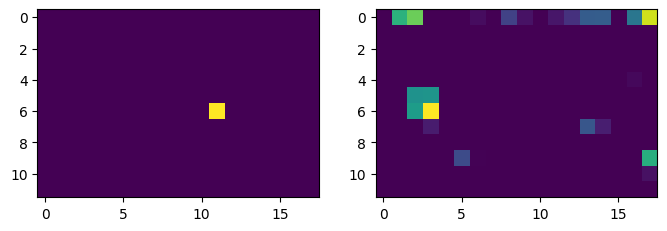

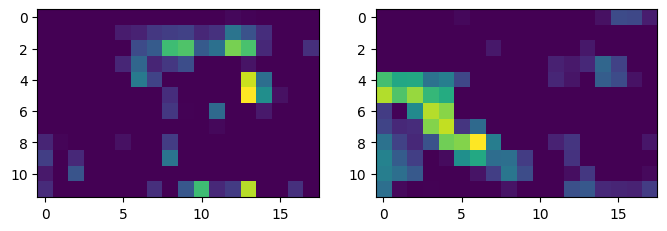

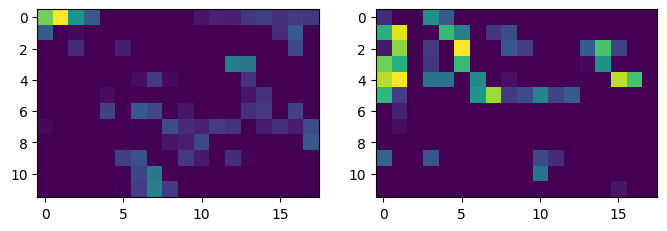

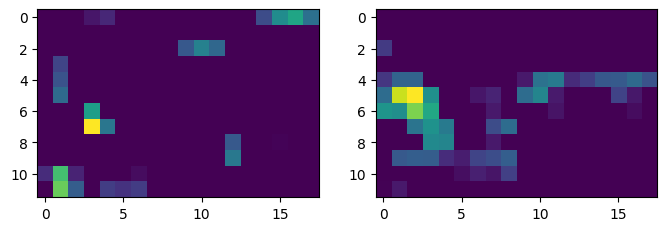

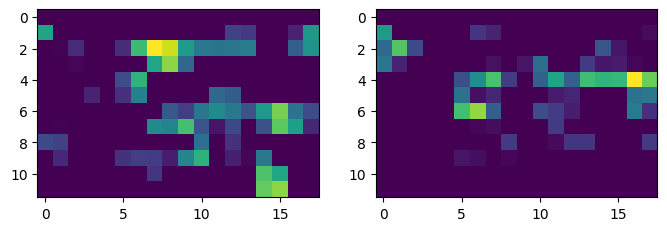

In [17]:
for idxx in range(5):
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    feature_imgs = [i[idxx].detach().numpy() for i in out_testt] # 5 kênh đầu tiên trong số n kênh của feature_img
    # detach() tách tensor ra khỏi đồ thị tính toán để sau này không tính gradient cho nó nữa
    fig, axes = display_img(feature_imgs, fig, axes)

# Display grid Mapping

- vẽ ra các anchor (các điểm) ở ảnh đầu vào mà số anchor ở chiều rộng bằng width của ảnh feature map và số anchor ở chiều dài bằng height của ảnh feature map

In [47]:
scale_center = img_size[0]/feature_img_height

In [65]:
centers_x, centers_y = generate_anchor_centers((feature_img_height, feature_img_width), scale_center)

(<Figure size 800x400 with 2 Axes>, <Axes: >)

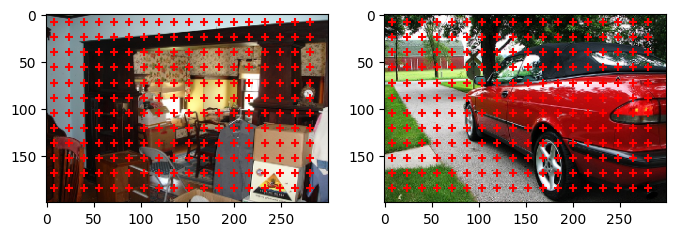

In [66]:
fig1, axes1 = plt.subplots(1,2, figsize=(8,4))
display_img(img_data_testt, fig1, axes1)
display_anchor_centers(centers_x, centers_y, fig1, axes1[0])
display_anchor_centers(centers_x, centers_y, fig1, axes1[1])

# Region proposal network

# Trash

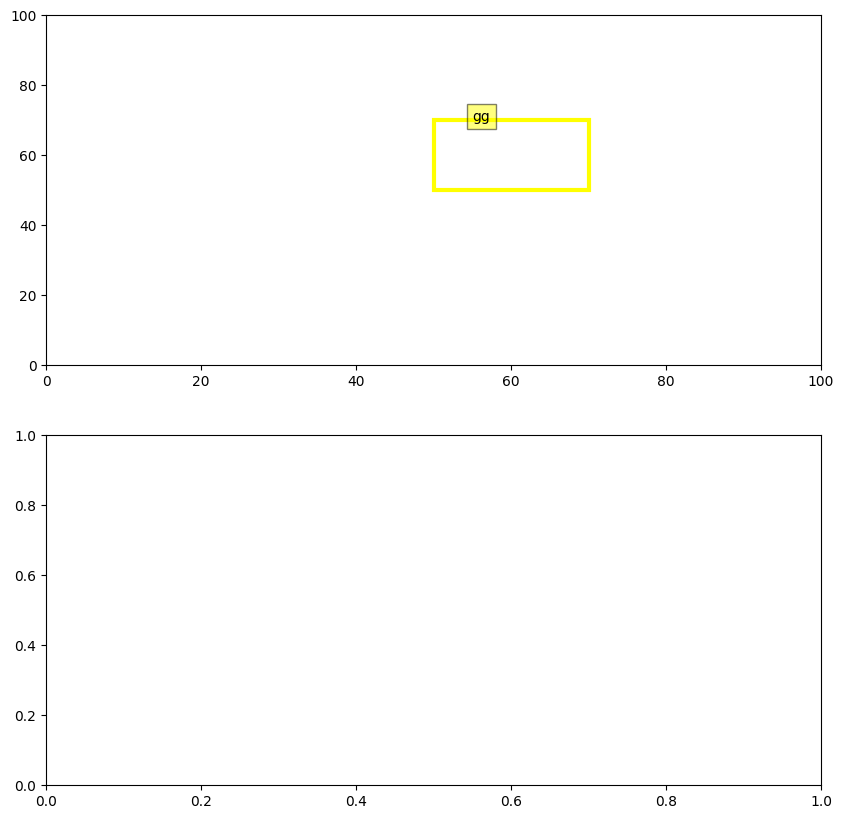

In [16]:
rect = patches.Rectangle((50, 50), 20, 20, linewidth=3, edgecolor='yellow', facecolor='none')

# Tạo hình và trục
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(10)

# Thêm hình chữ nhật vào trục
ax[0].add_patch(rect)

# Đặt giới hạn trục để đảm bảo hình chữ nhật nằm trong phạm vi hiển thị
ax[0].set_xlim(0, 100)  # Xác định phạm vi trục X
ax[0].set_ylim(0, 100)  # Xác định phạm vi trục Y
ax[0].text(50 + 5, 50 + 20, 'gg', bbox=dict(facecolor='yellow', alpha=0.5))
# Hiển thị biểu đồ
plt.show()